## WeatherBench 2 Work

In [2]:
import apache_beam

In [3]:
import weatherbench2
import xarray as xr

In [4]:
forecast_path = 'gs://weatherbench2/datasets/hres/2016-2022-0012-64x32_equiangular_conservative.zarr'
obs_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-64x32_equiangular_conservative.zarr'
climatology_path = 'gs://weatherbench2/datasets/era5-hourly-climatology/1990-2019_6h_64x32_equiangular_conservative.zarr'

In [118]:
xr.open(forecast_path)

array([199823.22, 200147.69], dtype=float32)

In [97]:
xr.open_zarr(obs_path)

<xarray.Dataset>
Dimensions:                                           (time: 92044,
                                                       longitude: 64,
                                                       latitude: 32, level: 13)
Coordinates:
  * latitude                                          (latitude) float64 -87....
  * level                                             (level) int64 50 ... 1000
  * longitude                                         (longitude) float64 0.0...
  * time                                              (time) datetime64[ns] 1...
Data variables: (12/38)
    10m_u_component_of_wind                           (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind                           (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    10m_wind_speed                                    (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    2m_temperature                                    (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    ...                                                ...
    type_of_high_vegetation                           (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    type_of_low_vegetation                            (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    u_component_of_wind                               (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind                               (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    vertical_velocity                                 (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    wind_speed                                        (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>

In [ ]:
climatology = xr.open_zarr(climatology_path)
climatology

In [58]:
import os
print(os.getcwd())

c:\Users\arche\4th Year Diss\Archer-4th-Year-Diss


In [40]:
from weatherbench2 import config

paths = config.Paths(
    forecast=forecast_path,
    obs=obs_path,
    output_dir='./',   # Directory to save evaluation results
)

In [41]:
selection = config.Selection(
    variables=[
        'geopotential',
        '2m_temperature'
    ],
    levels=[500, 850],
    time_slice=slice('2020-01-01', '2020-12-31'),
)

In [42]:
data_config = config.Data(selection=selection, paths=paths)

In [43]:

from weatherbench2.metrics import MSE, ACC

eval_configs = {
  'deterministic': config.Eval(
      metrics={
          'mse': MSE(), 
          'acc': ACC(climatology=climatology) 
      },
  )
}

In [44]:
from weatherbench2.regions import SliceRegion, ExtraTropicalRegion

regions = {
    'global': SliceRegion(),
    'tropics': SliceRegion(lat_slice=slice(-10, 10)),
    'extra-tropics': ExtraTropicalRegion(),
}

eval_configs = {
  'deterministic': config.Eval(
      metrics={
          'mse': MSE(), 
          'acc': ACC(climatology=climatology) 
      },
      regions=regions
  )
}

In [ ]:
from weatherbench2.evaluation import evaluate_in_memory
evaluate_in_memory(data_config, eval_configs)

In [22]:
results = xr.open_dataset('./deterministic.nc')
print(results)

test = results.sel(metric = 'mse', level = 850)
print(test['geopotential'].isnull())
print(results.sel(metric = 'mse', level = 850)['geopotential'].values)




<xarray.Dataset>
Dimensions:         (lead_time: 41, metric: 2, level: 2)
Coordinates:
  * lead_time       (lead_time) timedelta64[ns] 0 days 00:00:00 ... 10 days 0...
  * metric          (metric) object 'acc' 'mse'
  * level           (level) int32 500 850
Data variables:
    geopotential    (metric, lead_time, level) float64 ...
    2m_temperature  (metric, lead_time) float64 ...
<xarray.DataArray 'geopotential' (lead_time: 41)>
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])
Coordinates:
  * lead_time  (lead_time) timedelta64[ns] 0 days 00:00:00 ... 10 days 00:00:00
    metric     <U3 'mse'
    level      int32 850
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan n

In [21]:
geopotential_values = results['geopotential'].values
print(results)
print(geopotential_values.shape)

print(geopotential_values[:,:,0])

NameError: name 'results' is not defined

In [83]:
results = xr.concat(
    [
    results,
    results.sel(metric=['mse']).assign_coords(metric=['rmse']) ** 0.5
    ],
    dim='metric'
)

array([0.99958751, 0.99960745, 0.99919485, 0.99918863, 0.99861874,
       0.99840055, 0.99747869, 0.99691364, 0.995603  , 0.99458492,
       0.99252413, 0.99075045, 0.98763458, 0.98469715, 0.98020307,
       0.97575813, 0.96934508, 0.96298133, 0.95431291, 0.9454928 ,
       0.93435492, 0.92304466, 0.9092302 , 0.89519184, 0.87844481,
       0.86153516, 0.84207021, 0.82257733, 0.80075497, 0.7793906 ,
       0.75622167, 0.7334473 , 0.70903192, 0.68533846, 0.66096998,
       0.6376533 , 0.61389917, 0.59097026, 0.56730423, 0.5444894 ,
       0.5215291 ])

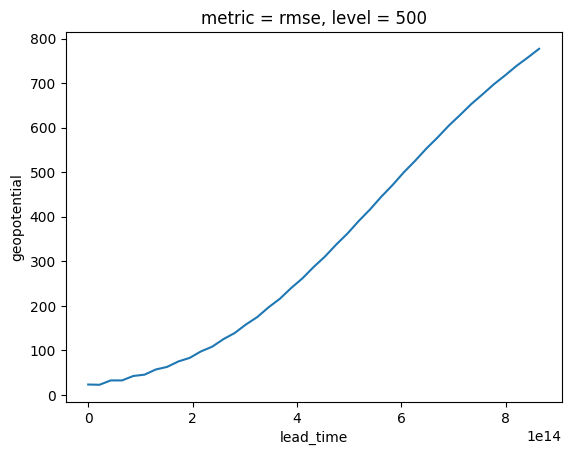

In [92]:
results['geopotential'].sel(metric='rmse', level=500).plot()

results['geopotential'].sel(metric='acc', level=500).values



In [71]:
##Testing on even smaller 1d date
from weatherbench2.regions import SliceRegion, ExtraTropicalRegion
from weatherbench2.evaluation import evaluate_in_memory

paths1 = config.Paths(
    forecast=forecast_path,
    obs=obs_path,
    output_dir='./',   # Directory to save evaluation results
)

selection1 = config.Selection(
    variables=[
        'geopotential',
    ],
    levels=[500],
    time_slice=slice('2020-06-01', '2020-12-31'),
)

data_config1 = config.Data(selection=selection1, paths=paths1)

regions1 = {
    'global': SliceRegion(),
    'tropics': SliceRegion(lat_slice=slice(-10, 10)),
    'extra-tropics': ExtraTropicalRegion(),
}

eval_configs1 = {
  'deterministic4': config.Eval(
      metrics={
          'mse': MSE(),
          'acc': ACC(climatology=climatology) 
      },
      regions=regions1
  )
}


evaluate_in_memory(data_config1, eval_configs1)



[20.14169764 17.74860028 26.59244509 22.73666492 28.36544384 27.49983314
 34.18618776 31.32797232 36.48441396 32.48283366 37.9573631  34.87051275
 41.27299674 36.96156765 42.54190721 38.53343578 44.41874035 40.44711481
 47.05807153 43.30739019 49.67421114 46.41958337 53.01314023 49.76786332
 56.48349181 53.00049545 59.13665816 56.45546911 62.67132646 60.35611267
 65.70243663 63.70108446 68.76725896 67.47476776 72.15230892 71.5693407
 75.58349078 75.73860409 79.65695566 79.65674959 83.50525206]


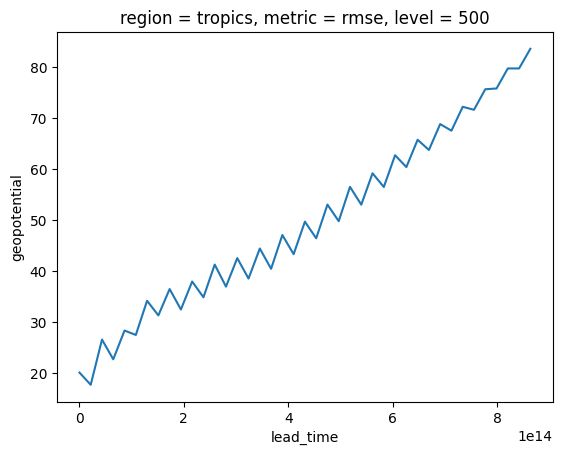

In [168]:
results4 = xr.open_dataset('./deterministic4.nc')

results4 = xr.concat(
    [
    results4,
    results4.sel(metric=['mse']).assign_coords(metric=['rmse']) ** 0.5
    ],
    dim='metric'
)

print(results4['geopotential'].sel(metric='rmse',level=500, region = 'tropics').values)

results4['geopotential'].sel(metric='rmse', level=500, region = 'tropics').plot()


In [121]:
###### Now trying to select data myself
##Preprocessing
#https://sites.research.google/weatherbench/faq/ info on region levels


# Tropics: -20° < lat < 20°

# Extra-tropics: |lat| > 20°

# Northern hemisphere: lat > 20°

# Southern hemisphere: lat < -20°

# Europe: 35° < lat < 75°, -12.5° < lon < 42.5°

# North America: 25° < lat < 60°, -120° < lon < -75°

# North Atlantic: 25° < lat < 60°, -70° < lon < -20°

# North Pacific: 25° < lat < 60°, 145° < lon < -130°

# East Asia: 25° < lat < 60°, 102.5° < lon < 150°

# AusNZ: -45° < lat < -12.5°, 120° < lon < 175°

# Arctic: 60° < lat < 90°

# Antarctic: -90° < lat < -60°


results4 = xr.open_dataset('./deterministic4.nc')
results4

<xarray.Dataset>
Dimensions:       (lead_time: 41, region: 3, metric: 2, level: 1)
Coordinates:
  * lead_time     (lead_time) timedelta64[ns] 0 days 00:00:00 ... 10 days 00:...
  * region        (region) object 'global' 'tropics' 'extra-tropics'
  * metric        (metric) object 'acc' 'mse'
  * level         (level) int32 500
Data variables:
    geopotential  (metric, region, lead_time, level) float64 ...

In [138]:



forecastdata = xr.open_zarr(forecast_path)
obsdata = xr.open_zarr(obs_path)

obsdata

#xr.open_zarr('gs://weatherbench2/datasets/hres/2016-2022-0012-64x32_equiangular_conservative.zarr/geopotential')

<xarray.Dataset>
Dimensions:                                           (time: 92044,
                                                       longitude: 64,
                                                       latitude: 32, level: 13)
Coordinates:
  * latitude                                          (latitude) float64 -87....
  * level                                             (level) int64 50 ... 1000
  * longitude                                         (longitude) float64 0.0...
  * time                                              (time) datetime64[ns] 1...
Data variables: (12/38)
    10m_u_component_of_wind                           (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind                           (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    10m_wind_speed                                    (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    2m_temperature                                    (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    ...                                                ...
    type_of_high_vegetation                           (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    type_of_low_vegetation                            (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    u_component_of_wind                               (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind                               (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    vertical_velocity                                 (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    wind_speed                                        (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>

In [142]:
forecastdata

<xarray.Dataset>
Dimensions:                   (time: 5114, prediction_timedelta: 41,
                               longitude: 64, latitude: 32, level: 13)
Coordinates:
  * latitude                  (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                     (level) int32 50 100 150 200 ... 700 850 925 1000
  * longitude                 (longitude) float64 0.0 5.625 ... 348.8 354.4
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 00:00:00...
  * time                      (time) datetime64[ns] 2016-01-01 ... 2022-12-31...
Data variables: (12/16)
    10m_u_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    ...                        ...
    total_precipitation_24hr  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_6hr   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    vertical_velocity         (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    wind_speed                (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>

In [139]:
#forecastdata['geopotential'].sel(level=500)

#tropics 
fdata = forecastdata['geopotential'].sel(level=500, time = slice('2020-06-01', '2020-12-31'), latitude = slice(-10, 10))
odata = obsdata['geopotential'].sel(level=500, time = slice('2020-06-01', '2020-12-31'), latitude = slice(-10, 10))


In [148]:
#fdata #time: 428prediction_timedelta: 41longitude: 64latitude: 4
odatafulltime = odata
odatahalftime =odata[::2,:,:] # time: 856longitude: 64latitude:
odatahalftime

<xarray.DataArray 'geopotential' (time: 428, longitude: 64, latitude: 4)>
dask.array<getitem, shape=(428, 64, 4), dtype=float32, chunksize=(50, 64, 4), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -8.437 -2.813 2.813 8.438
    level      int64 500
  * longitude  (longitude) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
  * time       (time) datetime64[ns] 2020-06-01 ... 2020-12-31T12:00:00
Attributes:
    long_name:      Geopotential
    short_name:     z
    standard_name:  geopotential
    units:          m**2 s**-2

In [223]:
fdata


<xarray.DataArray 'geopotential' (time: 428, prediction_timedelta: 41,
                                  longitude: 64, latitude: 4)>
dask.array<getitem, shape=(428, 41, 64, 4), dtype=float32, chunksize=(4, 1, 64, 4), chunktype=numpy.ndarray>
Coordinates:
  * latitude              (latitude) float64 -8.437 -2.813 2.813 8.438
    level                 int32 500
  * longitude             (longitude) float64 0.0 5.625 11.25 ... 348.8 354.4
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 00:00:00 ......
  * time                  (time) datetime64[ns] 2020-06-01 ... 2020-12-31T12:...
Attributes:
    long_name:      Geopotential
    short_name:     z
    standard_name:  geopotential
    units:          m**2 s**-2

In [181]:
errors = odatahalftime.values - fdata[:,0,:,:].values

In [183]:
print(errors)
print(errors.shape)

[[[ 15.644531    23.585938    34.734375    13.691406  ]
  [ 13.875       25.710938    28.570312    19.523438  ]
  [ 25.003906    40.691406    21.902344    11.292969  ]
  ...
  [ 37.121094    23.386719    -4.4375     -16.421875  ]
  [ 22.316406    23.265625    15.558594    -5.5898438 ]
  [ 23.933594     3.6015625    3.2460938   19.734375  ]]

 [[  1.171875    14.453125     1.515625    18.742188  ]
  [  8.03125     15.902344   -10.707031     1.9921875 ]
  [ 35.17578     24.101562     8.4453125    3.4726562 ]
  ...
  [  6.1015625   23.648438     6.046875    21.347656  ]
  [ 17.839844    31.28125      5.3007812   -5.921875  ]
  [ -4.6523438   13.316406     8.230469    11.9375    ]]

 [[ 12.363281    43.433594    12.144531    26.601562  ]
  [ 14.1796875   18.328125    -9.421875    17.792969  ]
  [ 29.117188    18.199219   -12.359375    16.070312  ]
  ...
  [  0.0859375   -6.5507812  -22.828125   -10.3515625 ]
  [ -2.6992188    0.11328125  -1.6523438   11.582031  ]
  [  8.464844    26.632812

In [182]:
import math
math.sqrt(sum(sum(sum(errors**2)))/(428*64*4))

#true 20.14169764

20.14269290688035

[57835.98  57830.664 57895.523 57849.07  57777.31  57767.78  57705.17
 57706.703 57724.42  57782.324 57777.266 57840.766 57804.86  57788.47
 57761.57  57673.484 57678.477 57672.266 57637.18  57702.17  57696.918]
57851.625


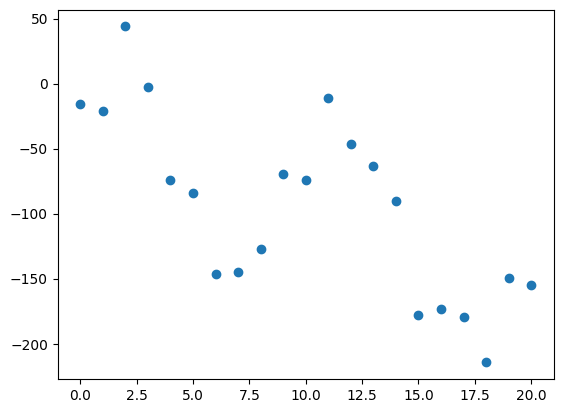

In [197]:
#Need to figure out shifting time
import matplotlib.pyplot as plt
import numpy as np


fdata[:,2,:,:].values

fdatatest = fdata[:,::2,:,:]

print(fdatatest[0,:,0,0].values)

print(odatahalftime[0,0,0].values)

x = np.array(fdatatest[0,:,0,0].values-57851.625)
y = np.array(range(0, 21))

plt.scatter(y, x)
plt.show()


In [218]:
errorslist = []
for i in range(0,21):
    errorsi = odatahalftime.values - fdatatest[:,i,:,:].values
    val = math.sqrt(sum(sum(sum(errorsi**2)))/(428*64*4))
    errorslist.append(val)

In [ ]:
errorslist = []
for i in range(0,21):
    errorsi = odatahalftime.values - fdatatest[:,i,:,:].values
    val = math.sqrt(sum(sum(sum(errorsi**2)))/(428*64*4))
    errorslist.append(val)

[20.14269290688035, 55.05369352333, 73.16811024546502, 94.66801853042365, 105.7506980324281, 111.80184328183034, 111.17011859619288, 111.38497797170412, 106.74873327620692, 110.26774975265441, 111.75048610569804, 118.23156383519542, 122.83987516236958, 127.78341576064534, 127.80978035060943, 129.913759811337, 126.7558939808264, 127.7475000669856, 125.76302049794428, 127.86490753697534, 128.53093262916659]


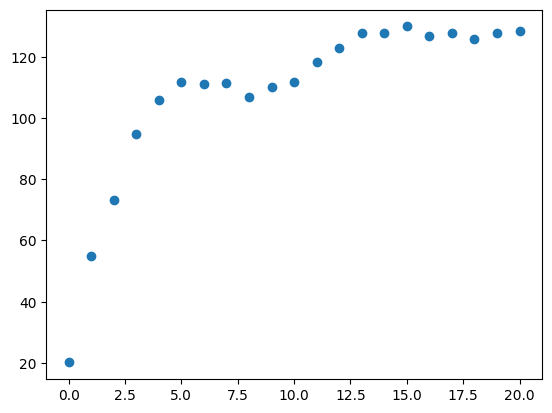

In [224]:
#What you would expect, but not 
print(errorslist)
x = np.array(errorslist)
y = np.array(range(0, 21))

plt.scatter(y, x)
plt.show()

#True values for tropics
[20.14169764 17.74860028 26.59244509 22.73666492 28.36544384 27.49983314
 34.18618776 31.32797232 36.48441396 32.48283366 37.9573631  34.87051275
 41.27299674 36.96156765 42.54190721 38.53343578 44.41874035 40.44711481
 47.05807153 43.30739019 49.67421114 46.41958337 53.01314023 49.76786332
 56.48349181 53.00049545 59.13665816 56.45546911 62.67132646 60.35611267
 65.70243663 63.70108446 68.76725896 67.47476776 72.15230892 71.5693407
 75.58349078 75.73860409 79.65695566 79.65674959 83.50525206]

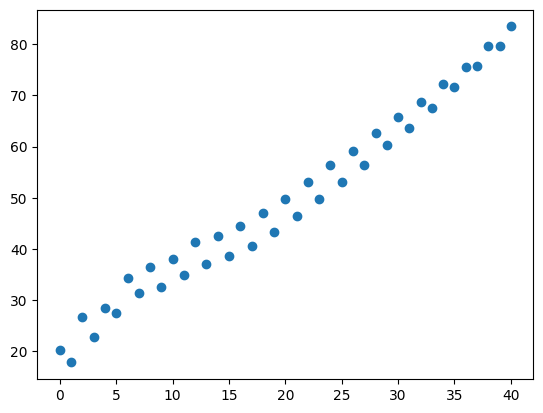

In [221]:
x=np.array([20.14169764,17.74860028,26.59244509,22.73666492,28.36544384,27.49983314,34.18618776,31.32797232,36.48441396,32.48283366,37.9573631,34.87051275,41.27299674,36.96156765,42.54190721,38.53343578,44.41874035,40.44711481,47.05807153,43.30739019,49.67421114,46.41958337,53.01314023,49.76786332,56.48349181,53.00049545,59.13665816,56.45546911,62.67132646,60.35611267,65.70243663,63.70108446,68.76725896,67.47476776,72.15230892,71.5693407,75.58349078,75.73860409,79.65695566,79.65674959,83.50525206])
y = np.array(range(0, 41))

plt.scatter(y, x)
plt.show()

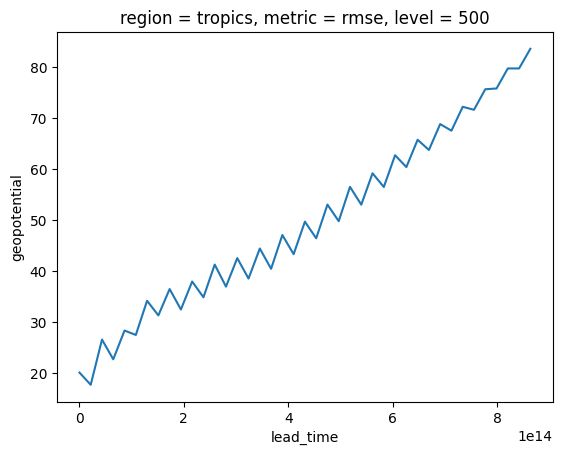

In [222]:
results4['geopotential'].sel(metric='rmse', level=500, region = 'tropics').plot()